# Dogs vs Cats

Using a neural network, we will build a model to determine wether an animal on a photo is a dog or a cat.

## About the dataset 

This dataset contains 12500 pictures containing dogs and 12500 pictures containing cats. The goal is to build a model which can detect if a picture contains a dog or a cat.

## History

The dogs vs cats dataset refers to a dataset used for a Kaggle machine learning competition held in 2013.

The dataset is comprised of photos of dogs and cats provided as a subset of photos from a much larger dataset of 3 million manually annotated photos. The dataset was developed as a partnership between Petfinder.com and Microsoft.

The dataset was originally used as a CAPTCHA (or Completely Automated Public Turing test to tell Computers and Humans Apart), that is, a task that it is believed a human finds trivial, but cannot be solved by a machine, used on websites to distinguish between human users and bots. Specifically, the task was referred to as “Asirra” or Animal Species Image Recognition for Restricting Access, a type of CAPTCHA. The task was described in the 2007 paper titled “Asirra: A CAPTCHA that Exploits Interest-Aligned Manual Image Categorization“.

At the time that the competition was posted, the state-of-the-art result was achieved with an SVM and described in a 2007 paper with the title “Machine Learning Attacks Against the Asirra CAPTCHA” (PDF) that achieved 80% classification accuracy. It was this paper that demonstrated that the task was no longer a suitable task for a CAPTCHA soon after the task was proposed.

In [1]:
# import necessary liberies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.image import imread
%matplotlib inline
import seaborn as sns

from os import listdir
from numpy import asarray
from numpy import save
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

import sys
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator


import warnings
warnings.filterwarnings('ignore')

## Let's take a look some of the images

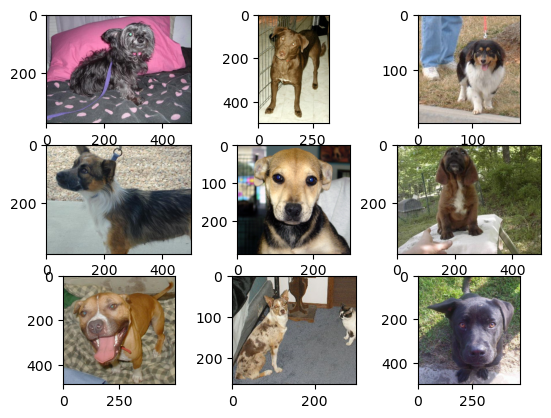

In [2]:
# Dogs
folder = 'dogvcats_neural/PetImages/'
# show some images
for i in range(9):
    pyplot.subplot(330 + 1 + i)
    filename = folder + "Dog/" + str(i) + '.jpg'
    image = imread(filename)
    pyplot.imshow(image)
pyplot.show()

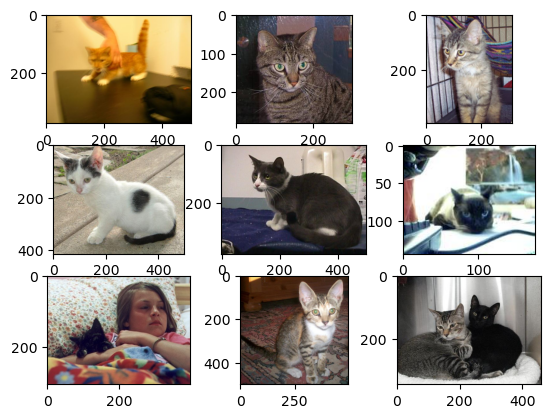

In [3]:
# cats
# show some images
for i in range(9):
    pyplot.subplot(330 + 1 + i)
    filename = folder + "Cat/" + str(i) + '.jpg'
    image = imread(filename)
    pyplot.imshow(image)
pyplot.show()

# Analysis

From the first 9 dog and cat images we can see some things to take note of:

1. Some images contain multiple dogs or multiple cats
2. In some images, other animals or Humans are visible
-> in some cases, a cat can be seen in a dog picture and vice versa like in row 3 column 2 of the dog pictures. After a quick scroll through, these images are extremely rare in the dataset, so it shouldn't affect the result if we don't do anything.
3. Images have different dimensions 
4. Images contains a wide spread of dog and cat breeds



# Preprocessing

Having images with different dimensions makes it harder to learn a good model. Therefore we will standardize the pictures to the same size to have less input variables. Due to limited Computing Power, we will select a size of 175x175 pixels, more pixels could lead to better results. Also had to delete some broken files that caused errors

In [4]:
photos, labels = list(), list()
# enumerate files in the directory
for file in listdir(folder + "Dog/"):
    photo = load_img(folder + "Dog/" + file, target_size=(175, 175))
   # convert to numpy array
    photo = img_to_array(photo)
 # store
    photos.append(photo)
    labels.append(1.0)
# convert to a numpy arrays
photos = asarray(photos)
labels = asarray(labels)
save('dogs_photos.npy', photos)
save('dogs_labels.npy', labels)
print("Dogs done")
photos, labels = list(), list()
for file in listdir(folder + "Cat/"):
    photo = load_img(folder + "Cat/" + file, target_size=(175, 175))
     # convert to numpy array
    photo = img_to_array(photo)
     # store
    photos.append(photo)
    labels.append(0.0)
# convert to a numpy arrays
photos = asarray(photos)
labels = asarray(labels)
print(photos.shape, labels.shape)
save('cats_photos.npy', photos)
save('cats_labels.npy', labels)
print("Cats done")

Dogs done
(12499, 175, 175, 3) (12499,)
Cats done


In [5]:
from numpy import load
dog_photos = load('dogs_photos.npy')
dog_labels = load('dogs_labels.npy')
cat_photos = load('cats_photos.npy')
cat_labels = load('cats_labels.npy')
print("Loaded data")

Loaded data


We need test and train data. For this we randomly chose 25% of the images to be test data. In the end, around 6250 images total should be in the test folder

In [6]:
# organize dataset into a useful structure
from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random
# combine photos and labels
photos = dog_photos + cat_photos
labels = dog_labels + cat_labels
# create directories
dataset_home = 'dogvcats_neural/'
subdirs = ['train/', 'test/']
for subdir in subdirs:
    # create label subdirectories
    labeldirs = ['dogs/', 'cats/']
    for labldir in labeldirs:
        newdir = dataset_home + subdir + labldir
        makedirs(newdir, exist_ok=True)
seed(42)
# around 25% should be test data
test_ratio = 0.25
# copy training dataset images into subdirectories
# dogs
for file in listdir(folder + "Dog/"):
    src = folder + "Dog/" + file
    dst_dir = 'train/'
    if random() < test_ratio:
        dst_dir = 'test/'
    dst = dataset_home + dst_dir + 'dogs/'  + file
    copyfile(src, dst)
print("Dogs sorted")
# cats
for file in listdir(folder + "Cat/"):
    src = folder + "Cat/" + file
    dst_dir = 'train/'
    if random() < test_ratio:
        dst_dir = 'test/'
    dst = dataset_home + dst_dir + 'cats/'  + file
    copyfile(src, dst)
print("Cats sorted")

Dogs sorted
Cats sorted


In [7]:
import os
count = 0
for root_dir, cur_dir, files in os.walk(dataset_home + "test/"):
    count += len(files)
print("There are " + str(count) + " total images chosen as test data")
print("Equals " + str(round((count/25000)*100, 2)) + " % of all images")

There are 6278 total images chosen as test data
Equals 25.11 % of all images


# Building a first CNN baseline

Let's just test with some CNN's.

Each layer will use the ReLU activation function and the He weight initialization, which are generally best practices.

In [8]:
#build model
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(175, 175, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu', kernel_initializer='he_uniform', input_shape = photos[1:]),
    Dense(2, activation='softmax')
])

model.compile(optimizer="adam", 
              loss="sparse_categorical_crossentropy", 
              metrics=["accuracy"])


# create data generator
datagen = ImageDataGenerator(rescale=1.0/255.0)

# prepare iterators
train_it = datagen.flow_from_directory('dogvcats_neural/train/',
    class_mode='binary', batch_size=64, target_size=(175, 175))
test_it = datagen.flow_from_directory('dogvcats_neural/test/',
    class_mode='binary', batch_size=64, target_size=(175, 175))

# fit model
history1 = model.fit(train_it,
    validation_data=test_it, validation_steps=len(test_it), epochs=7)




Found 18720 images belonging to 2 classes.
Found 6278 images belonging to 2 classes.
Epoch 1/7


293/293 [==============================] - 620s 2s/step - loss: 1.3748 - accuracy: 0.5813 - val_loss: 0.6249 - val_accuracy: 0.6739
Epoch 2/7
293/293 [==============================] - 514s 2s/step - loss: 0.5547 - accuracy: 0.7153 - val_loss: 0.5536 - val_accuracy: 0.7203
Epoch 3/7
293/293 [==============================] - 474s 2s/step - loss: 0.4453 - accuracy: 0.7883 - val_loss: 0.5547 - val_accuracy: 0.7305
Epoch 4/7
293/293 [==============================] - 498s 2s/step - loss: 0.3212 - accuracy: 0.8600 - val_loss: 0.5454 - val_accuracy: 0.7471
Epoch 5/7
293/293 [==============================] - 492s 2s/step - loss: 0.2012 - accuracy: 0.9181 - val_loss: 0.6862 - val_accuracy: 0.7267
Epoch 6/7
293/293 [==============================] - 488s 2s/step - loss: 0.1184 - accuracy: 0.9562 - val_loss: 0.8584 - val_accuracy: 0.7434
Epoch 7/7
293/293 [==============================] - 495s 

After 3 Epochs, the model starts to become overfitted to the train data.

Let's improve the model, 72 % is not a good starting point.

In [9]:
#build model
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(175, 175, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu', kernel_initializer='he_uniform', input_shape = photos[1:]),
    Dense(2, activation='softmax')
])

model.compile(optimizer="adam", 
              loss="sparse_categorical_crossentropy", 
              metrics=["accuracy"])


# create data generator
datagen = ImageDataGenerator(rescale=1.0/255.0)

# prepare iterators
train_it = datagen.flow_from_directory('dogvcats_neural/train/',
    class_mode='binary', batch_size=64, target_size=(175, 175))
test_it = datagen.flow_from_directory('dogvcats_neural/test/',
    class_mode='binary', batch_size=64, target_size=(175, 175))

# fit model
history2 = model.fit(train_it,
    validation_data=test_it, validation_steps=len(test_it), epochs=7)

Found 18720 images belonging to 2 classes.
Found 6278 images belonging to 2 classes.
Epoch 1/7
293/293 [==============================] - 543s 2s/step - loss: 0.7041 - accuracy: 0.6488 - val_loss: 0.5223 - val_accuracy: 0.7428
Epoch 2/7
293/293 [==============================] - 536s 2s/step - loss: 0.4991 - accuracy: 0.7548 - val_loss: 0.5094 - val_accuracy: 0.7478
Epoch 3/7
293/293 [==============================] - 495s 2s/step - loss: 0.4292 - accuracy: 0.8021 - val_loss: 0.4443 - val_accuracy: 0.7917
Epoch 4/7
293/293 [==============================] - 491s 2s/step - loss: 0.3458 - accuracy: 0.8491 - val_loss: 0.4399 - val_accuracy: 0.7972
Epoch 5/7
293/293 [==============================] - 492s 2s/step - loss: 0.2502 - accuracy: 0.8971 - val_loss: 0.4694 - val_accuracy: 0.8014
Epoch 6/7
293/293 [==============================] - 493s 2s/step - loss: 0.1647 - accuracy: 0.9356 - val_loss: 0.5802 - val_accuracy: 0.7840
Epoch 7/7
293/293 [==============================] - 493s 2s/st

In [10]:
#build model
model = Sequential([
    Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(175, 175, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu', kernel_initializer='he_uniform', input_shape = photos[1:]),
    Dense(128, activation='relu', kernel_initializer='he_uniform'),
    Dense(2, activation='softmax')
])

model.compile(optimizer="adam", 
              loss="sparse_categorical_crossentropy", 
              metrics=["accuracy"])


# create data generator
datagen = ImageDataGenerator(rescale=1.0/255.0)

# prepare iterators
train_it = datagen.flow_from_directory('dogvcats_neural/train/',
    class_mode='binary', batch_size=64, target_size=(175, 175))
test_it = datagen.flow_from_directory('dogvcats_neural/test/',
    class_mode='binary', batch_size=64, target_size=(175, 175))

# fit model
history3 = model.fit(train_it,
    validation_data=test_it, validation_steps=len(test_it), epochs=7)

Found 18720 images belonging to 2 classes.
Found 6278 images belonging to 2 classes.
Epoch 1/7
293/293 [==============================] - 930s 3s/step - loss: 0.6622 - accuracy: 0.5962 - val_loss: 0.5721 - val_accuracy: 0.7088
Epoch 2/7
293/293 [==============================] - 927s 3s/step - loss: 0.5141 - accuracy: 0.7435 - val_loss: 0.5160 - val_accuracy: 0.7342
Epoch 3/7
293/293 [==============================] - 926s 3s/step - loss: 0.4367 - accuracy: 0.7949 - val_loss: 0.4131 - val_accuracy: 0.8108
Epoch 4/7
293/293 [==============================] - 926s 3s/step - loss: 0.3677 - accuracy: 0.8365 - val_loss: 0.3737 - val_accuracy: 0.8391
Epoch 5/7
293/293 [==============================] - 930s 3s/step - loss: 0.3142 - accuracy: 0.8640 - val_loss: 0.3529 - val_accuracy: 0.8482
Epoch 6/7
293/293 [==============================] - 925s 3s/step - loss: 0.2529 - accuracy: 0.8946 - val_loss: 0.3657 - val_accuracy: 0.8485
Epoch 7/7
293/293 [==============================] - 924s 3s/st

In [11]:
#model.save('predict_CvD_cnn.model')

In [18]:
# Build dataframe to display data

newelement = []
vis = []
x = 0
#add model 1
while x < 7:
    newelement = []
    newelement.append(1)
    newelement.append(1 + x)
    newelement.append(history1.history["loss"][x])
    newelement.append(history1.history["accuracy"][x])
    newelement.append(history1.history["val_loss"][x])
    newelement.append(history1.history["val_accuracy"][x])
    vis.append(newelement)
    x = x + 1
x = 0
#add model 2
while x < 7:
    newelement = []
    newelement.append(2)
    newelement.append(1 + x)
    newelement.append(history2.history["loss"][x])
    newelement.append(history2.history["accuracy"][x])
    newelement.append(history2.history["val_loss"][x])
    newelement.append(history2.history["val_accuracy"][x])
    vis.append(newelement)
    x = x + 1
x = 0
#add model 3
while x < 7:
    newelement = []
    newelement.append(3)
    newelement.append(1 + x)
    newelement.append(history3.history["loss"][x])
    newelement.append(history3.history["accuracy"][x])
    newelement.append(history3.history["val_loss"][x])
    newelement.append(history3.history["val_accuracy"][x])
    vis.append(newelement)
    x = x + 1
x = 0


vis_df = pd.DataFrame(data=vis, columns=["Model", "Epoch", "loss", "accuracy", "val_loss", "val_accuracy"])
print(vis_df)

    Model  Epoch      loss  accuracy  val_loss  val_accuracy
0       1      1  1.374802  0.581250  0.624933      0.673941
1       1      2  0.554656  0.715278  0.553595      0.720293
2       1      3  0.445322  0.788301  0.554739      0.730487
3       1      4  0.321213  0.859989  0.545358      0.747053
4       1      5  0.201231  0.918109  0.686214      0.726665
5       1      6  0.118401  0.956197  0.858377      0.743390
6       1      7  0.062593  0.978900  0.974082      0.745938
7       2      1  0.704062  0.648825  0.522253      0.742752
8       2      2  0.499141  0.754754  0.509432      0.747850
9       2      3  0.429218  0.802137  0.444332      0.791653
10      2      4  0.345802  0.849092  0.439939      0.797228
11      2      5  0.250242  0.897115  0.469430      0.801370
12      2      6  0.164693  0.935630  0.580181      0.784008
13      2      7  0.108589  0.957372  0.693399      0.792291
14      3      1  0.662192  0.596154  0.572077      0.708824
15      3      2  0.5140

[Text(0.5, 1.0, 'Loss per Epoch')]

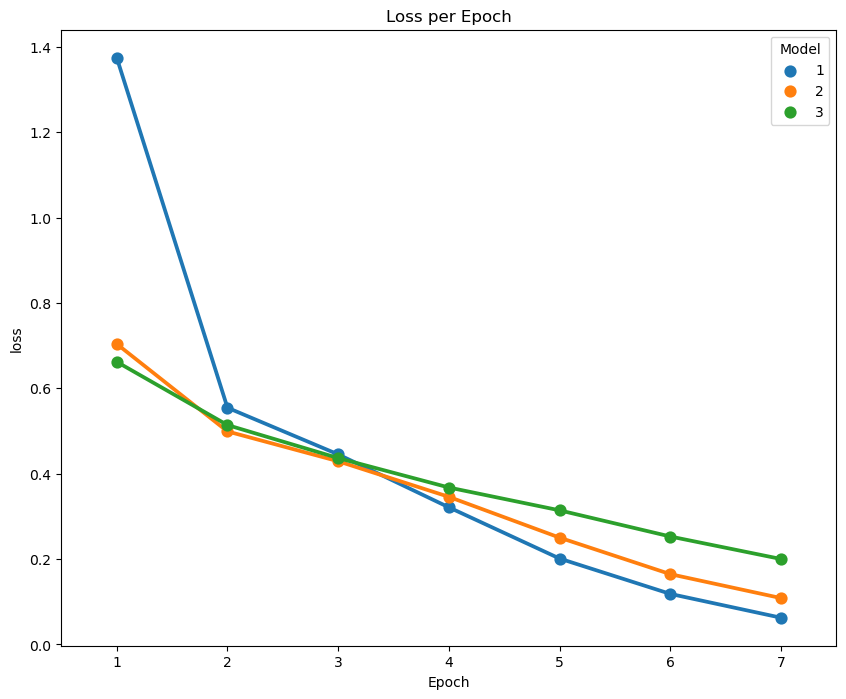

In [19]:
#anlysis of data by vizualisation
fig,ax=plt.subplots(figsize=(10,8))
sns.pointplot(data=vis_df,x='Epoch',y='loss',hue='Model',ax=ax,capsize=.2)
ax.set(title='Loss per Epoch')

[Text(0.5, 1.0, 'Accuracy per Epoch')]

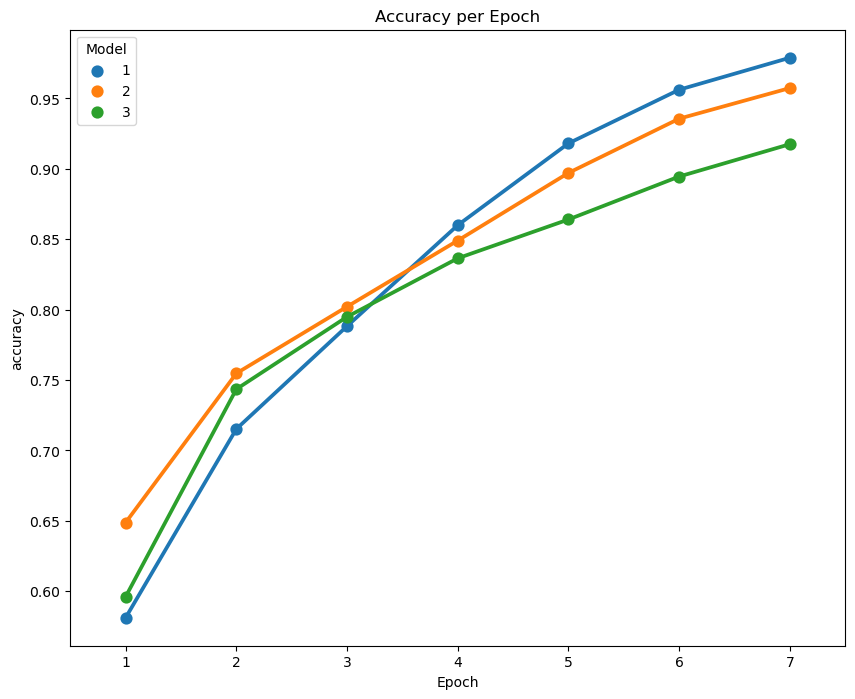

In [20]:
#anlysis of data by vizualisation
fig,ax=plt.subplots(figsize=(10,8))
sns.pointplot(data=vis_df,x='Epoch',y='accuracy',hue='Model',ax=ax,capsize=.2)
ax.set(title='Accuracy per Epoch')

[Text(0.5, 1.0, 'Validation Loss per Epoch')]

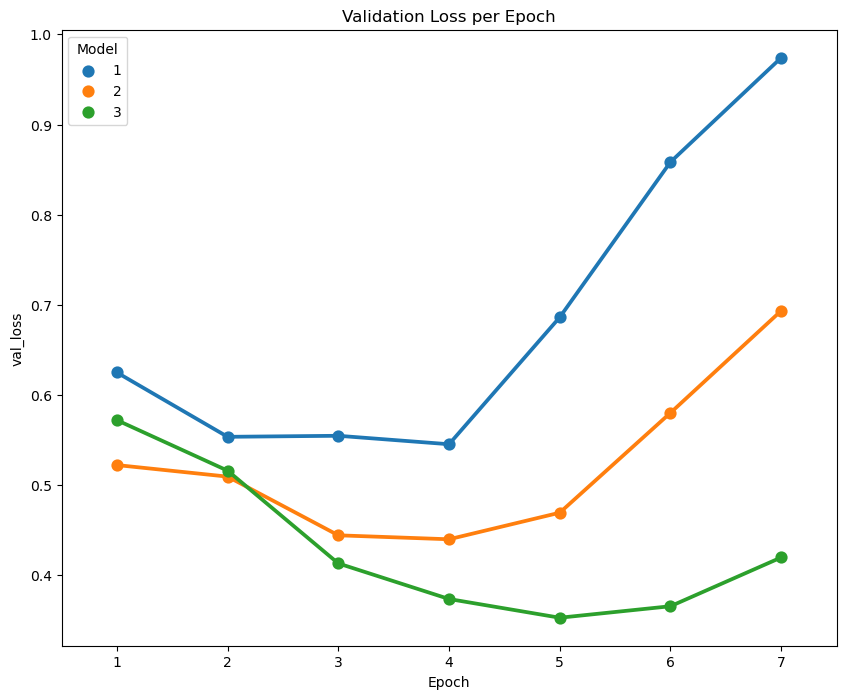

In [21]:
#anlysis of data by vizualisation
fig,ax=plt.subplots(figsize=(10,8))
sns.pointplot(data=vis_df,x='Epoch',y='val_loss',hue='Model',ax=ax,capsize=.2)
ax.set(title='Validation Loss per Epoch')

[Text(0.5, 1.0, 'Validation Accuracy per Epoch')]

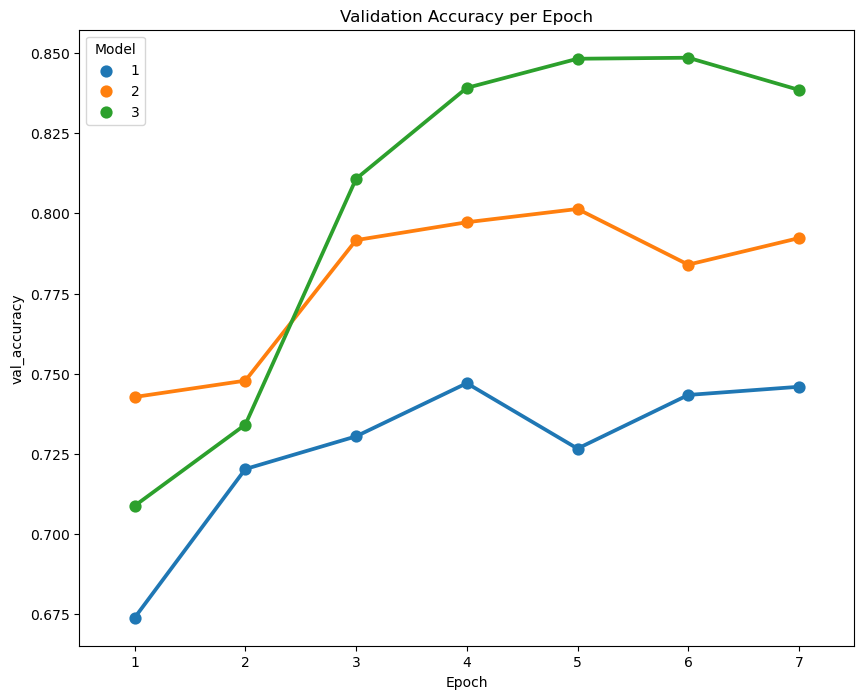

In [22]:
#anlysis of data by vizualisation
fig,ax=plt.subplots(figsize=(10,8))
sns.pointplot(data=vis_df,x='Epoch',y='val_accuracy',hue='Model',ax=ax,capsize=.2)
ax.set(title='Validation Accuracy per Epoch')